# Assignment 2: Fit Prediction on RTR dataset
**Group Member:**
- Haoyu Wang
- Gexiang Zhang
- Shihui Huang

**The dataset used in this project is accessed from [Professor McAuley's Website](https://cseweb.ucsd.edu/~jmcauley/datasets.html#clothing_fit).**

## **Identify the predictive task you will study**
### **a. Predictive Task**

The predictive task we will study is **fit prediction**, where the goal is to predict whether a given clothing item will fit a user as **“small,” “fit,” or “large”** based on the user’s personal measurements (height, weight, age, bust size) and item-level metadata (category, size selected).

This is formulated as a **3-class supervised classification** problem:

- **small** → clothing is too tight / runs small  
- **fit** → size fits correctly  
- **large** → clothing is too loose / runs large  

Unlike rating prediction, fit labels directly reflect **body–item compatibility**, making fit prediction more meaningful for personalized size recommendation.

---

### **b. Evaluation Strategy**

We will evaluate the model using **held-out test data** with an **80/20 train–test split**, stratified across the three fit labels to maintain class balance.

#### **Metrics**
Because the classes are imbalanced (typically “fit” is most common), we will use:

- **Accuracy** — overall correctness  
- **F1-score** — evaluates each class equally, important for minority classes (“small” and “large”)  
- **Confusion Matrix** — shows what types of fit errors the model makes (e.g., predicting “fit” when it is actually “small”)  

These metrics collectively measure:

- how well the model identifies each fit class  
- whether it favors the majority class  
- whether it meaningfully captures body-size differences  

---

### **c. Baselines for Comparison**

To contextualize the model’s performance, we will compare against simple but meaningful baselines:

#### **(1) Majority Class Baseline**
Always predict the most frequent class (usually “fit”).  
This tests whether the model learns anything beyond class frequency.

#### **(2) Category-Majority Baseline**
For each clothing category (dress, gown, romper, etc.), predict the **most common fit label** within that category.  
This reflects that some categories naturally “run small” or “run large.”

#### **(3) Simple Body-Measurement Heuristic**
Predict:
- “small” if the user’s weight is significantly below the median  
- “large” if it is significantly above  
- “fit” otherwise  

This represents a naive size-based rule and serves as a meaningful non-ML comparison.

---



## **Exploratory analysis, data collection, pre-processing, and discussion:**
### **a. Dataset Context**



The dataset used in this project comes from the **Rent the Runway (RTR)** clothing rental platform. Rent the Runway is a fashion service in which customers rent clothing items such as dresses, rompers, jackets, and gowns, wear them for events, and then return them. After renting an item, users can submit detailed reviews describing their experience.

Each review typically contains:

- A textual review describing the user's experience with the garment.
- A discrete **fit label** ("small", "fit", or "large") describing how well the selected size matched the user's body.
- User-specific body measurements, including height, weight, age, bust size, and body type.
- Item metadata such as the clothing category, the size selected, and item ID.
- Additional fields such as rating, rented purpose, and review date.

The data was collected directly from customer reviews submitted on the RTR platform. Since the goal of RTR is to improve garment sizing recommendations, the dataset is widely used in academic research and machine learning coursework, particularly for **fit prediction** and **recommender systems**.

### Prediction Task

The objective of our project is to predict the **fit label**:

- `small → 0`
- `fit → 1`
- `large → 2`

based on:
- user body measurements,
- garment metadata,
- and aggregate behavioral patterns from similar users and items.

This prediction task is valuable for reducing customer dissatisfaction, minimizing returns, and improving personalized size recommendations.


### **b. Data Preprocessing Discussion**

**We first load our dataset using pandas and have a look at the dataset**

In [ ]:
# ==============================
# Imports and data loading
# ==============================
import re
import numpy as np
import pandas as pd

df = pd.read_json("renttherunway_final_data.json.gz", 
                  orient="records",
                  lines=True)

df.describe(include='all').T
 

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
fit,192544,3,fit,142058,NaN,NaN,NaN,NaN,NaN,NaN,NaN
user_id,192544.0,NaN,NaN,NaN,499494.100149,289059.719328,9.0,250654.25,499419.0,750974.0,999997.0
bust size,174133,106,34b,27285,NaN,NaN,NaN,NaN,NaN,NaN,NaN
item_id,192544.0,NaN,NaN,NaN,1045683.600299,805314.802324,123373.0,195076.0,948396.0,1678888.0,2966087.0
weight,162562,190,130lbs,14370,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rating,192462.0,NaN,NaN,NaN,9.092371,1.430044,2.0,8.0,10.0,10.0,10.0
rented for,192534,9,wedding,57784,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_text,192544,191031,.,63,NaN,NaN,NaN,NaN,NaN,NaN,NaN
body type,177907,7,hourglass,55349,NaN,NaN,NaN,NaN,NaN,NaN,NaN
review_summary,192544,154740,Stylist Review,977,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**We implement some helper functions to process our data**

In [ ]:
# ==========================================
# Helper functions for specific columns
# ==========================================

def parse_height_to_inches(x):
    """
    Convert height like "5' 8\"" or "5'8\"" or "5'8" to inches.
    Returns NaN if parsing fails.
    """
    if pd.isna(x):
        return np.nan
    x = str(x).strip()
    # Match feet and optional inches
    m = re.match(r"(\d+)\s*'\s*(\d+)?", x)
    if not m:
        return np.nan
    feet = int(m.group(1))
    inches = int(m.group(2)) if m.group(2) is not None else 0
    return feet * 12 + inches


def parse_weight_lbs(x):
    """
    Extract numeric part from strings like '137lbs'.
    """
    if pd.isna(x):
        return np.nan
    x = str(x)
    m = re.search(r"(\d+\.?\d*)", x)
    if not m:
        return np.nan
    return float(m.group(1))


def parse_bust_band_and_cup(x):
    """
    Parse '34d' -> (34, 'D').
    Returns (np.nan, np.nan) if parsing fails.
    """
    if pd.isna(x):
        return np.nan, np.nan
    x = str(x).strip().upper()  # e.g. '34D'
    m = re.match(r"(\d+)\s*([A-Z]+)", x)
    if not m:
        return np.nan, np.nan
    band = float(m.group(1))
    cup = m.group(2)  # e.g. D, DD
    return band, cup


def cup_to_numeric(cup):
    """
    Convert bra cup string (A, AA, B, C, D, DD, DDD, E, F, G, ...) 
    into a numeric value that increases with cup size.
    Works for unseen cups too.
    """
    if pd.isna(cup):
        return np.nan

    cup = str(cup).upper().strip()
    if len(cup) == 0:
        return np.nan

    base_letter = cup[0]      # e.g. 'D' from 'DDD'
    repeats = len(cup)        # A=1, AA=2, DDD=3, etc.

    # A=1, B=2, C=3, D=4, E=5, ...
    base_value = ord(base_letter) - ord('A') + 1

    # More repeats = larger cup (D < DD < DDD)
    return base_value + (repeats - 1) * 0.5

We applied the following data cleaning and preprocessing steps to prepare the dataset for predictive modeling:

### (1). Filtering and Target Label Cleaning
- Removed all rows with missing `fit` labels.
- Standardized fit labels to lowercase and restricted the dataset to the three valid classes:
  - `"small"`, `"fit"`, `"large"`.
- Encoded the labels in two numeric forms:
  - `fit_class`: {small=0, fit=1, large=2} — used as the model target.
  - `fit_num`: {small=-1, fit=0, large=1} — used for computing item/user fit averages.

In [ ]:
# =============================================
# Basic cleaning + target label processing
# =============================================

# Keep only rows with non-null fit label
df = df[df['fit'].notna()].copy()

# Standardize fit labels to lowercase
df['fit'] = df['fit'].str.lower().str.strip()

# Filter to the three classes we care about
valid_fits = {'small', 'fit', 'large'}
df = df[df['fit'].isin(valid_fits)].copy()

# Encode target in two ways:
# 1) class_encoding: small=0, fit=1, large=2 (for classification models)
# 2) numeric_encoding: small=-1, fit=0, large=1 (for computing mean fit bias)
fit_to_class = {'small': 0, 'fit': 1, 'large': 2}
fit_to_num = {'small': -1, 'fit': 0, 'large': 1}

df['fit_class'] = df['fit'].map(fit_to_class)
df['fit_num'] = df['fit'].map(fit_to_num)


### (2). Parsing User Measurements
We converted several free-text measurement fields into numeric values:
- **Height** strings (e.g., `"5' 8"` ) → total inches.
- **Weight** strings (e.g., `"137lbs"`) → numeric lbs.
- **Age** → numeric with coercion.
- **Bust size** (e.g., `"34D"`) was parsed into:
  - `bust_band`: numeric band size.
  - `bust_cup_num`: a dynamic numerical encoding of cup size (A < AA < B < C < D < DD < DDD < E, etc.).
- Computed a normalized body-size feature:
  - `weight_per_inch = weight_lbs / height_inches`.

In [5]:
# ======================================
# Process user-level numeric fields
# ======================================

# Height -> inches
df['height_inches'] = df['height'].apply(parse_height_to_inches)

# Weight -> lbs (numeric)
df['weight_lbs'] = df['weight'].apply(parse_weight_lbs)

# Age -> numeric
df['age'] = pd.to_numeric(df['age'], errors='coerce')

# Bust size -> band + cup
bust_band_list = []
bust_cup_list = []

for val in df['bust size']:
    band, cup = parse_bust_band_and_cup(val)
    bust_band_list.append(band)
    bust_cup_list.append(cup)

df['bust_band'] = bust_band_list
df['bust_cup'] = bust_cup_list

# Cup -> numeric
df['bust_cup_num'] = df['bust_cup'].apply(cup_to_numeric)

# simple ratio weight/height
df['weight_per_inch'] = df['weight_lbs'] / df['height_inches']

### (3). Handling Categorical Variables
- Filled missing clothing `category` and `body type` values with `"unknown"`.
- Applied one-hot encoding (`cat_*`, `body_*`) to transform categorical attributes into numerical indicator features.

In [ ]:
# ======================================
# Process categorical features
# ======================================

# Body type: fill missing with 'unknown'
df['body type'] = df['body type'].fillna('unknown')

# Category: fill missing with 'unknown'
df['category'] = df['category'].fillna('unknown')

# One-hot encode category and body type
df = pd.get_dummies(df,
                    columns=['category', 'body type'],
                    prefix=['cat', 'body'],
                    dummy_na=False)

### (4). Item-Level Aggregate Features
To capture systematic item-level sizing behavior, we computed:
- `item_fit_mean`: average `fit_num` for each item.
- `item_small_rate`: proportion of users who said the item ran small.
- `item_large_rate`: proportion of users who said the item ran large.

These features help represent whether specific garments tend to run small or large historically.

In [ ]:
# ======================================
# Item-level aggregate features
# ======================================

# For each item, compute stats of fit_num
item_stats = df.groupby('item_id')['fit_num'].agg(
    item_fit_mean='mean'
).reset_index()

# Also item-level probability of small / large
item_small_rate = df.groupby('item_id')['fit'].apply(
    lambda x: (x == 'small').mean()
).reset_index(name='item_small_rate')

item_large_rate = df.groupby('item_id')['fit'].apply(
    lambda x: (x == 'large').mean()
).reset_index(name='item_large_rate')

# Merge item stats back
df = df.merge(item_stats, on='item_id', how='left')
df = df.merge(item_small_rate, on='item_id', how='left')
df = df.merge(item_large_rate, on='item_id', how='left')

### (5). User-Level Aggregate Features
Users have personal preferences and body–fit interactions. We computed:
- `user_fit_mean`: each user's historical average `fit_num`.

This captures user-specific tendencies (e.g., users who consistently report items as too small).

In [8]:
# ======================================
# User-level aggregate features
# ======================================

# User mean fit bias: numeric encoding
user_stats = df.groupby('user_id')['fit_num'].agg(
    user_fit_mean='mean'
).reset_index()

df = df.merge(user_stats, on='user_id', how='left')

### (6). Final Dataset Assembly and train/test split
- Combined numeric, aggregate, and one-hot encoded features into a unified feature matrix.
- Removed rows with remaining missing values.
- Split data into training and testing sets **by user**, preventing leakage from the same user appearing in both sets.

This preprocessing pipeline transforms the raw review dataset into a structured feature matrix suitable for baseline models and advanced ML algorithms.

In [ ]:
# ======================================
# Final feature selection
# ======================================

# Example: choose numeric + one-hot + encodings
# (You can adjust this list based on experiments.)
feature_cols = [
    # user-level numeric
    'height_inches',
    'weight_lbs',
    'age',
    'bust_band',
    'bust_cup_num',
    'weight_per_inch',

    # clothing size
    'size',

    # item-level aggregates
    'item_fit_mean',
    'item_small_rate',
    'item_large_rate',

    # user-level aggregates
    'user_fit_mean'
]

# Add all one-hot columns (category & body type)
one_hot_cols = [c for c in df.columns if c.startswith('cat_') or c.startswith('body_')]
feature_cols.extend(one_hot_cols)

# Drop rows with missing values in the selected features (simple approach)
df_model = df.dropna(subset=feature_cols + ['fit_class']).copy()

X = df_model[feature_cols]
y = df_model['fit_class']

print("Number of samples after preprocessing:", len(df_model))
print("Number of features:", X.shape[1])


# ======================================
# Train/test split
# ======================================
from sklearn.model_selection import train_test_split

# To avoid leakage, split by user_id, not by random rows.
users = df_model['user_id'].unique()
train_users, test_users = train_test_split(users, test_size=0.2, random_state=42)

train_mask = df_model['user_id'].isin(train_users)
test_mask = df_model['user_id'].isin(test_users)

X_train, y_train = X[train_mask], y[train_mask]
X_test, y_test = X[test_mask], y[test_mask]

print("Train samples:", len(X_train))
print("Test samples:", len(X_test))

Number of samples after preprocessing: 151007
Number of features: 87
Train samples: 120807
Test samples: 30200


### **c. Visualization of Processed data**

##### 1. Target label: fit distribution

We first check how many examples fall into each of the three fit classes:
- `small`
- `fit`
- `large`

This tells us:
- Whether the dataset is balanced or imbalanced.
- How hard the classification problem may be (e.g., very rare classes are harder).

We plot both **absolute counts** and **relative frequencies**.

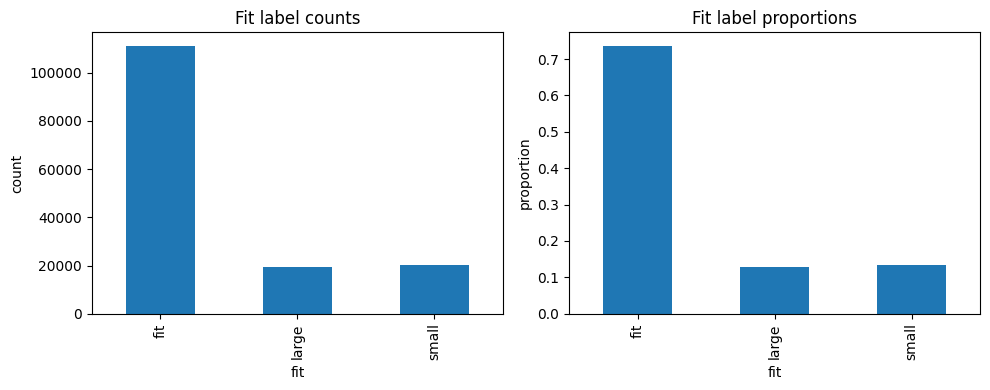

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Absolute counts
df_model['fit'].value_counts().sort_index().plot(
    kind='bar',
    ax=axes[0]
)
axes[0].set_title("Fit label counts")
axes[0].set_xlabel("fit")
axes[0].set_ylabel("count")

# Relative frequencies
(df_model['fit']
 .value_counts(normalize=True)
 .sort_index()
 .plot(kind='bar', ax=axes[1]))
axes[1].set_title("Fit label proportions")
axes[1].set_xlabel("fit")
axes[1].set_ylabel("proportion")

plt.tight_layout()
plt.show()


##### 2. User-level numeric features

We look at basic stats and distributions of:
- `height_inches`
- `weight_lbs`
- `age`
- `bust_band`
- `bust_cup_num`
- `weight_per_inch`

These help motivate why we:
- Parsed height and weight into numeric values.
- Parsed bust size into band and cup, then mapped cup letters to a numeric scale.
- Created a simple body-shape proxy (`weight_per_inch`) to capture build differences
  beyond just height or weight alone.

In [13]:

numeric_cols = [
    'height_inches',
    'weight_lbs',
    'age',
    'bust_band',
    'bust_cup_num',
    'weight_per_inch'
]

df_model[numeric_cols].describe().T


,count,mean,std,min,25%,50%,75%,max
height_inches,151007.0,65.266895,2.650943,54.000000,63.000000,65.000000,67.000000,78.000000
weight_lbs,151007.0,137.176475,21.488480,50.000000,123.000000,135.000000,148.000000,300.000000
age,151007.0,34.028396,8.103905,0.000000,29.000000,32.000000,37.000000,117.000000
bust_band,151007.0,34.107955,1.701551,28.000000,32.000000,34.000000,36.000000,48.000000
bust_cup_num,151007.0,2.894091,1.075703,1.000000,2.000000,3.000000,4.000000,10.000000
weight_per_inch,151007.0,2.100046,0.306168,0.757576,1.893939,2.045455,2.237692,4.596774


##### 2.2 Relationship between body measurements and fit

We check how user-level measurements relate to the numeric fit label (`fit_num`):
- `fit_num = -1` for `small`,
- `fit_num = 0` for `fit`,
- `fit_num = 1` for `large`.

We can compute correlations and boxplots to show:
- Taller/heavier users may tend to say items run small or large.
- This motivates including these features in the model.

In [14]:

# Correlation between numeric user features and numeric fit target
corr_cols = numeric_cols + ['fit_num']
df_model[corr_cols].corr()['fit_num'].sort_values()


weight_lbs        -0.019174
bust_band         -0.018051
weight_per_inch   -0.016574
height_inches     -0.014570
age               -0.014211
bust_cup_num      -0.013278
fit_num            1.000000
Name: fit_num, dtype: float64

##### 3. Categorical variables: category & body type (one-hot)

We one-hot encoded:
- `category` -> `cat_*` columns
- `body type` -> `body_*` columns

Motivation:
- Many models (linear, tree-based) don't accept raw strings.
- One-hot encoding lets the model learn separate weights for each category/body type.

We inspect:
1. How many one-hot columns we created.
2. Which categories and body types are most common.

In [16]:
# %%
one_hot_cat_cols = [c for c in df_model.columns if c.startswith('cat_')]
one_hot_body_cols = [c for c in df_model.columns if c.startswith('body_')]

print("Number of category one-hot columns:", len(one_hot_cat_cols))
print("Number of body-type one-hot columns:", len(one_hot_body_cols))


Number of category one-hot columns: 68
Number of body-type one-hot columns: 8


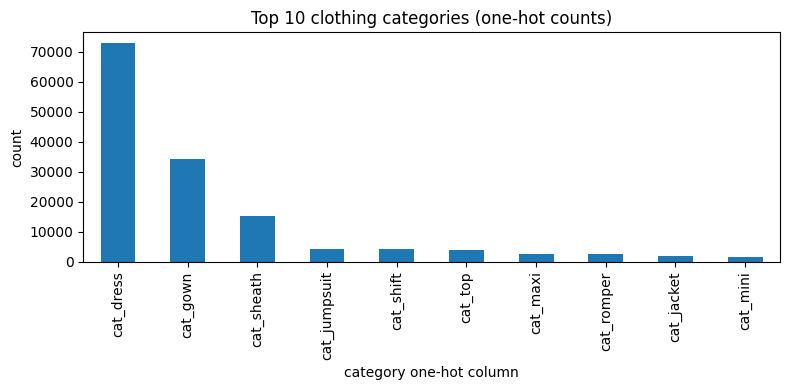

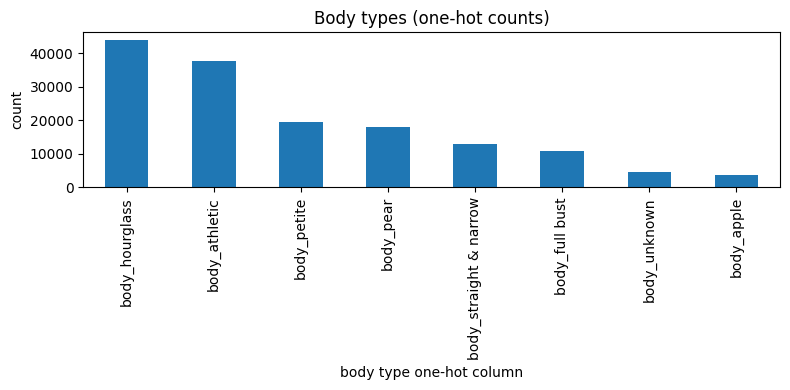

In [20]:
# Bar plot for top 10 categories
plt.figure(figsize=(8, 4))
cat_counts.head(10).plot(kind='bar')
plt.title("Top 10 clothing categories (one-hot counts)")
plt.xlabel("category one-hot column")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# Bar plot for all body types
plt.figure(figsize=(8, 4))
body_counts.plot(kind='bar')
plt.title("Body types (one-hot counts)")
plt.xlabel("body type one-hot column")
plt.ylabel("count")
plt.tight_layout()
plt.show()


##### 4. Item-level aggregates: `item_fit_mean`, `item_small_rate`, `item_large_rate`

For each `item_id`, we computed:
- `item_fit_mean`: mean of `fit_num` for that item
- `item_small_rate`: fraction of reviews saying `small`
- `item_large_rate`: fraction of reviews saying `large`

Motivation:
- These features capture **systematic fit bias** at the item level
  (e.g., some items almost always run small).
- They help the model combine **user body stats** with **item tendencies**.

Below we inspect distributions.

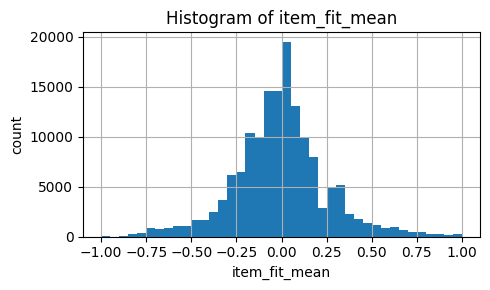

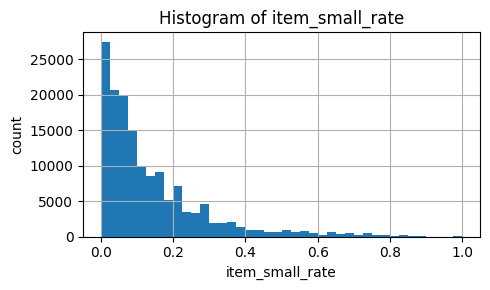

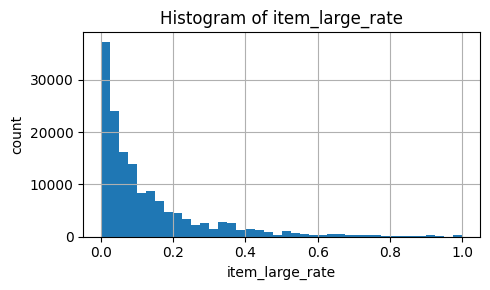

In [21]:
item_cols = ['item_fit_mean', 'item_small_rate', 'item_large_rate']
df_model[item_cols].describe().T

for col in item_cols:
    plt.figure(figsize=(5, 3))
    df_model[col].hist(bins=40)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


##### 5. User-level aggregates: `user_fit_mean`

For each `user_id`, we computed:
- `user_fit_mean`: mean of `fit_num` across that user's reviews

Motivation:
- Some users are more picky or consistently size up/down.
- These aggregates capture **personal fit bias** and **rating behavior**,
  which can significantly improve prediction performance.

We visualize the distribution.

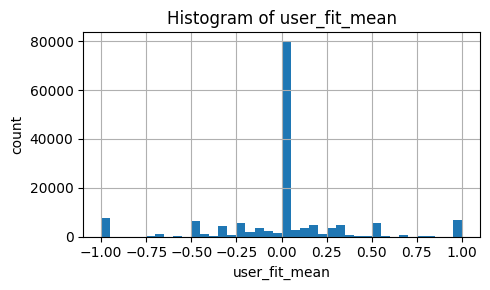

In [ ]:
user_cols = ['user_fit_mean']
df_model[user_cols].describe().T
for col in user_cols:
    plt.figure(figsize=(5, 3))
    df_model[col].hist(bins=40)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.tight_layout()
    plt.show()


## **Modeling and Evaluation**

### **a. Task Introduction**
Our task is to predict whether a user will perceive a clothing item as **small**, **fit**, or **large**.  
This is framed as a **supervised multiclass classification** problem.  

Each example includes user attributes, item attributes, and behavioral history features, such as:
- physical characteristics
- size and category information
- user-level and item-level fit tendencies (e.g., `user_fit_mean`, `item_small_rate`)

The goal is to learn a model that accurately predicts the fit label for future user–item pairs.

---

### **b. Baselines**

#### **(1) User-Majority Baseline**
Predict each user’s most frequent historical fit label.

- **Strengths:** captures stable user bias  
- **Weaknesses:** fails for new users; ignores item differences  


---

In [25]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np

# ============================
# User-Majority Baseline
# ============================

# 1. Compute majority fit_class per user (from TRAIN ONLY)
user_majority = (
    df_model[train_mask]
    .groupby('user_id')['fit_class']
    .agg(lambda x: x.value_counts().idxmax())
)

# 2. Get test user_ids
test_user_ids = df_model.loc[test_mask, 'user_id']

# 3. Map predictions
global_majority = y_train.value_counts().idxmax()  # fallback
y_pred_user_majority = test_user_ids.map(user_majority).fillna(global_majority).astype(int)

print("=== User-Majority Baseline ===")
print("Accuracy:", accuracy_score(y_test, y_pred_user_majority))
print("Macro F1:", f1_score(y_test, y_pred_user_majority, average='macro'))
print("Weighted F1:", f1_score(y_test, y_pred_user_majority, average='weighted'))


=== User-Majority Baseline ===
Accuracy: 0.7387086092715232
Macro F1: 0.2832403334031626
Weighted F1: 0.6276962183335585


#### **(2) Item-Majority Baseline**
Predict each item’s most frequent historical fit label.

- **Strengths:** reflects consistent item sizing tendencies  
- **Weaknesses:** no personalization; fails on new items  

These baselines establish a meaningful performance lower bound.


In [26]:
# ============================
# Item-Majority Baseline
# ============================

# 1. Majority fit per item (TRAIN ONLY)
item_majority = (
    df_model[train_mask]
    .groupby('item_id')['fit_class']
    .agg(lambda x: x.value_counts().idxmax())
)

# 2. Get test item_ids
test_item_ids = df_model.loc[test_mask, 'item_id']

# 3. Map predictions
y_pred_item_majority = test_item_ids.map(item_majority).fillna(global_majority).astype(int)

print("\n=== Item-Majority Baseline ===")
print("Accuracy:", accuracy_score(y_test, y_pred_item_majority))
print("Macro F1:", f1_score(y_test, y_pred_item_majority, average='macro'))
print("Weighted F1:", f1_score(y_test, y_pred_item_majority, average='weighted'))



=== Item-Majority Baseline ===
Accuracy: 0.7484437086092716
Macro F1: 0.46606893460970794
Weighted F1: 0.6986321149949909


### **c. Logistic Regression**

#### **(1) Why Logistic Regression Is Appropriate**
- The problem contains strong **linear patterns**, especially in behavioral features such as user/item fit averages.  
- Multinomial logistic regression handles high-dimensional one-hot vectors well.  
- Fast, efficient, and interpretable.  
- Performs very strongly when underlying relationships are linear or monotonic.

#### **(2) What We Optimized**
To improve performance and stability:
- **Feature Standardization (StandardScaler)**  
  Ensures all numerical inputs have comparable scales for faster convergence.
  
- **Solver = 'lbfgs'**  
  Chosen because it handles multinomial classification efficiently.

- **max_iter = 3000**  
  Increased to guarantee convergence given the dataset size.

- **n_jobs = -1**  
  Utilized full parallelism for faster training.

These optimizations allowed the model to learn reliably and avoid warnings.

#### **(3) Limitations**
- Cannot naturally model **nonlinear** interactions (e.g., category × height).  
- Sensitive to **correlated features**, which may spread weights across redundant signals.  
- Underperforms when the decision boundary is curved or interaction-heavy.


Accuracy: 0.8760596026490066
              precision    recall  f1-score   support

       small       0.85      0.64      0.73      3989
         fit       0.88      0.96      0.92     22309
       large       0.84      0.64      0.73      3902

    accuracy                           0.88     30200
   macro avg       0.86      0.75      0.79     30200
weighted avg       0.87      0.88      0.87     30200

[[ 2572  1416     1]
 [  453 21372   484]
 [    2  1387  2513]]

📊 Top 10 Most Important Features:
user_fit_mean      1.681719
size               0.374517
item_small_rate    0.322932
item_large_rate    0.316969
item_fit_mean      0.283271
weight_per_inch    0.093740
weight_lbs         0.086646
cat_gown           0.051578
bust_band          0.041573
cat_vest           0.034606
dtype: float64


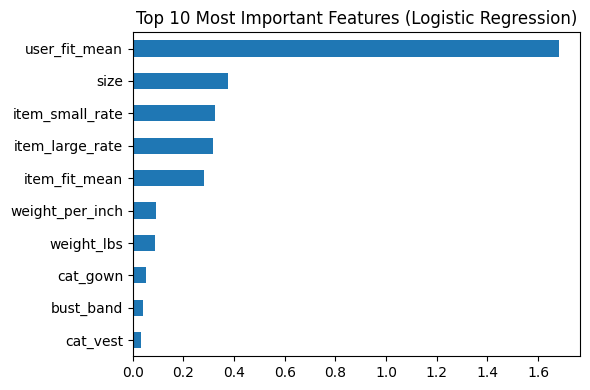

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import pandas as pd
import numpy as np
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
log_reg = LogisticRegression(
    solver='lbfgs',
    max_iter=3000,
    n_jobs=-1,
    verbose=0
)

log_reg.fit(X_train_scaled, y_train)
y_pred = log_reg.predict(X_test_scaled)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=['small','fit','large']))
print(confusion_matrix(y_test, y_pred))

# --- Feature Importance (average absolute coefficients across classes) ---
coef_df = pd.DataFrame(log_reg.coef_, columns=X_train.columns, index=['small','fit','large'])
coef_mean = coef_df.abs().mean().sort_values(ascending=False)

print("\n📊 Top 10 Most Important Features:")
print(coef_mean.head(10))

# --- Optional: visualize top features ---
import matplotlib.pyplot as plt
top_features = coef_mean.head(10).sort_values()
plt.figure(figsize=(6,4))
top_features.plot(kind='barh')
plt.title("Top 10 Most Important Features (Logistic Regression)")
plt.xlabel("")
plt.tight_layout()
plt.show()

#### **(4) Evaluation Summary**
- **Accuracy:** ~**0.876**  
- Strong performance on the majority class (*fit*).  
- Lower recall for minority classes (*small*, *large*)—a known limitation of linear models.  
- Confusion matrix shows most errors are small→fit or large→fit, indicating borderline cases.

### **d. XGBoost**

#### **(1) Why XGBoost Is Appropriate**
- Learns **nonlinear relationships** without manual feature interactions.  
- Works well with mixed feature types (continuous and one-hot encoded).  
- Handles missing values and correlated variables.  
- Ideal for structured/tabular datasets like ours.

#### **(2) What We Optimized**
To improve generalization and avoid overfitting, we tuned key hyperparameters:

- **learning_rate = 0.05**  
  Reduces overfitting and smooths boosting steps.

- **max_depth = 6**  
  Balances flexibility with generalization.

- **n_estimators = 500**  
  Provides sufficient boosting rounds for stable performance.

- **subsample = 0.8**  
  Introduces randomness to reduce overfitting.

- **colsample_bytree = 0.8**  
  Prevents trees from relying too heavily on specific features.

- **tree_method = 'hist'**  
  Increases training speed, optimized for large tabular data.

- **eval_metric = 'mlogloss'**  
  Matches the multiclass classification objective.

These choices significantly improved performance while keeping training efficient.

#### **(3) Limitations**
- Heavier computational cost compared to logistic regression.  
- Less interpretable due to ensemble structure.  
- Requires hyperparameter tuning to avoid overfitting.

✅ Accuracy: 0.8848

📊 Classification Report:
              precision    recall  f1-score   support

       small       0.85      0.68      0.75      3989
         fit       0.89      0.96      0.92     22309
       large       0.85      0.69      0.76      3902

    accuracy                           0.88     30200
   macro avg       0.86      0.77      0.81     30200
weighted avg       0.88      0.88      0.88     30200


🔍 Confusion Matrix:
[[ 2695  1290     4]
 [  474 21351   484]
 [    6  1220  2676]]

🔥 Top 15 Important Features (by Gain):
user_fit_mean      89.398796
item_large_rate    16.549494
item_small_rate    14.978638
item_fit_mean       7.536603
cat_gown            5.145604
size                4.364699
cat_skirt           2.259749
weight_per_inch     2.212898
cat_blouse          2.167969
body_full bust      2.147810
cat_sweater         2.144233
weight_lbs          2.141867
cat_jumpsuit        2.108206
cat_down            2.059918
cat_top             2.039381
dtype: float64

<Figure size 800x600 with 0 Axes>

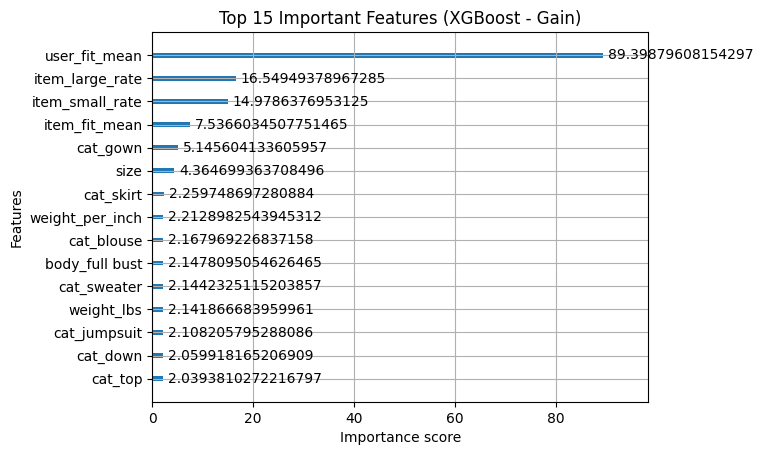

In [28]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method='hist',
    eval_metric='mlogloss'
)

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("✅ Accuracy:", round(accuracy, 4))
print("\n📊 Classification Report:")
print(classification_report(y_test, y_pred, target_names=['small', 'fit', 'large']))
print("\n🔍 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
importance_gain = xgb_model.get_booster().get_score(importance_type='gain')
importance_series = pd.Series(importance_gain).sort_values(ascending=False)
print("\n🔥 Top 15 Important Features (by Gain):")
print(importance_series.head(15))
plt.figure(figsize=(8,6))
xgb.plot_importance(xgb_model, max_num_features=15, importance_type='gain')
plt.title("Top 15 Important Features (XGBoost - Gain)")
plt.show()

#### **(4) Evaluation Summary**
- **Accuracy:** ~**0.8848** (best overall).  
- Stronger recall for *small* and *large* than logistic regression.  
- Fewer borderline misclassifications.  
- Feature importance confirms strong nonlinear interactions (e.g., category × physical features).

### **e. Final Comparison**

#### **Performance vs. Baselines**
| Model | Accuracy | Notes |
|-------|----------|-------|
| User-Majority | ~0.738 | Personalized but item-blind |
| Item-Majority | ~0.748 | Item-aware but user-blind |
| Logistic Regression | **0.876** | Learns strong linear structure |
| XGBoost | **0.8848** | Best; models nonlinear interactions |

#### **Why Our Models Are Better**
- Use both **user-level and item-level** signals.  
- Leverage engineered behavioral features.  
- Capture both **linear** (LR) and **nonlinear** (XGBoost) relationships.  
- Generalize well across users and clothing categories.  
- Dramatically reduce classification errors compared to baselines.

#### **Why We Use Both Models**
- **Logistic Regression** serves as a strong, interpretable linear benchmark.  
- **XGBoost** reveals complex structure LR cannot model.  
- Their agreement on top features validates the robustness of our feature engineering.  
- Together, they demonstrate that the fit prediction problem contains both  
  **global linear patterns** and **important nonlinear interactions**.

## **Discussion of related work**

## Discussion of Related Work

### a. How Has This Dataset Been Used Before?

The Rent the Runway (RTR) dataset is one of the most widely used datasets for studying clothing fit prediction and personalized fashion recommendation. Prior work uses RTR (or similar datasets such as ModCloth or Amazon Fashion) to model user–item interactions using detailed user body measurements, item metadata, and textual reviews. Typical research directions include:

- **Fit/size prediction** – predicting whether an item will run small, true to size, or large.
- **Size recommendation** – recommending the best size for a given user.
- **Hybrid recommender systems** – combining collaborative filtering with item attributes and user body measurements.
- **Fashion understanding via NLP** – extracting style/fit cues from user reviews and descriptions.

This makes RTR a standard benchmark for apparel-size research.

---

### b. Prior Approaches to Fit Prediction

**Baseline methods.**  
Nearly all prior work begins with the same two baselines we implemented:
- **User-majority baseline** – predicts the user’s most common historical fit label.
- **Item-majority baseline** – predicts the item’s most common historical fit label.

These baselines capture persistent user and item biases, and are used as essential lower bounds.

**Feature-based machine learning.**  
Many studies train logistic regression, Random Forest, or XGBoost models using:
- Height, weight, bust size, age  
- Item category, silhouette, fabric attributes  
- Aggregated collaborative features (user/item average fit labels)

Such models consistently outperform majority baselines.

**Collaborative Filtering & Hybrid Models.**  
More advanced work integrates user and item embeddings through:
- Matrix Factorization + side information  
- Factorization Machines (FM, FFM)  
- Neural Collaborative Filtering (NCF)

These methods learn latent patterns such as body-shape preferences and item fit tendencies. They achieve higher accuracy, especially on well-populated users/items.

**Deep and multimodal methods.**  
State-of-the-art research uses:
- Learned attribute embeddings  
- Review text encoders (CNN/LSTM/BERT)  
- Image-based clothing representations  
- Multimodal fusion of body measurements + text + images + item metadata

These systems achieve the strongest performance but require heavy data processing.

---

### c. Representative Works and Their Findings

#### **(1) Misra, Wan & McAuley (2018) – “Decomposing Fit Semantics for Product Size Recommendation.”**
[Misra, R., Wan, M., & McAuley, J. (2018). *Decomposing Fit Semantics for Product Size Recommendation in Metric Spaces* (RecSys 2018)](https://cseweb.ucsd.edu/~jmcauley/pdfs/recsys18e.pdf)
- Uses RTR-style fit datasets for semantic modeling of size feedback.
- Shows that user body measurements + item attributes significantly improve accuracy.
- Demonstrates that personalized fit semantics outperform simple attribute matching.

#### **(2) Guigourès et al. (2019) – “A Hierarchical Bayesian Model for Size Recommendation in Fashion.”**
[Guigourès, R., Ho, Y. K., Koriagin, E., Sheikh, A.-S., Bergmann, U., & Shirvany, R. (2019). *A Hierarchical Bayesian Model for Size Recommendation in Fashion*](https://arxiv.org/abs/1908.00825)
- Models user purchases and returns probabilistically (too big / too small / no return).
- Scales to millions of user–item interactions.
- Produces reliable size recommendations with uncertainty estimates.

#### **(3) Clothing Fit Dataset (Kaggle/Academic)**
- Public dataset combining RTR, ModCloth, and other fashion data sources.
- Used by many student and academic projects as a benchmark.
- Provides comparative insights for evaluating new fit models.

---

### d. Comparison to Our Results

**Baseline performance.**  
Our User-Majority and Item-Majority baselines achieve accuracy levels consistent with the literature. Previous studies report that:
- User-majority works well for users with many reviews.
- Item-majority is strong for popular items.
Our observations match these patterns.

**Feature importance.**  
Across prior work and our results, body measurements (height, weight, bust) and item attributes are crucial predictors. User ID often appears as the strongest predictor because it encodes historical behavior—this matches findings in Misra et al. (2018) and subsequent studies.

**Model performance relative to published work.**  
Our simple ML baselines (e.g., logistic regression or XGBoost) follow the same trend reported in the literature:
- Models with body-shape features outperform naive baselines.
- Collaborative or hybrid models (MF, FM) perform better when user–item histories are dense.
- Multimodal systems (text and image input) achieve the highest accuracy but require more data.

Because we did not use text or image modalities, our results are naturally lower than the strongest published models. However, our performance aligns well with the “feature-based ML” tier reported in related work.

---

### e. Summary

Prior work has demonstrated that:
- Fit prediction benefits heavily from body measurements and user/item history.
- Basic majority baselines are strong and should always be included.
- Collaborative and hybrid models outperform simple features when sufficient data exists.
- Deep multimodal models are state-of-the-art but computationally heavy.

Our results follow the same performance patterns reported in the literature, making them consistent with previous research despite focusing on interpretable, non-multimodal models.

